In [0]:
import pyspark
pyspark.__version__

Out[2]: '3.2.1'

In [0]:
from pyspark.sql.functions import col

import networkx as nx
import matplotlib.pyplot as plt

from graphframes import GraphFrame
from graphframes.examples import Graphs

In [0]:
# vertices - like Nodes. Note that column names are placed as list in the end
vertices = spark.createDataFrame([("MHK", "Manhattan", 103),
                                  ("EUG", "Eugene", 65),
                                  ("AMW", "Ames", 35),
                                  ("STW", "Stowe", 2),
                                  ("SEA", "Seattle", 10),
                                  ("RDM", "Bend", 70),
                                  ("QTN", "Queenstown", 1),
                                  ("PDX", "Portland", 3)], ["airport_id", "airport_name", "total_flights"])

In [0]:
# object vertices is a dataframe. Check it out
vertices.display()

airport_id,airport_name,total_flights
MHK,Manhattan,103
EUG,Eugene,65
AMW,Ames,35
STW,Stowe,2
SEA,Seattle,10
RDM,Bend,70
QTN,Queenstown,1
PDX,Portland,3


Output can only be rendered in Databricks

In [0]:
# edges will represent the flights between our vertices. 
# !!!Note that there are reqirements we need to meet to be able to create a graph data frame # in the future: edges dataframe needs to have 
# columns explicitly named "src" and "dst"
edges = spark.createDataFrame([("MHK", "EUG", 50),
                               ("EUG", "AMW", -10),
                               ("AMW", "EUG", 0),
                               ("PDX", "AMW", 0),
                               ("RDM", "PDX", -2),
                               ("RDM", "SEA", 10),
                               ("SEA", "MHK", 35),
                               ("MHK", "RDM", 25)], ["src", "dst", "delay"])

In [0]:
edges.display()

src,dst,delay
MHK,EUG,50
EUG,AMW,-10
AMW,EUG,0
PDX,AMW,0
RDM,PDX,-2
RDM,SEA,10
SEA,MHK,35
MHK,RDM,25


In [0]:
# instanciate a graph frame. This command will run into en error "ValueError: Vertex ID column id missing from vertex DataFrame"
flights_route = GraphFrame(vertices, edges)
print(flights_route)

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-3818980472860405> in <module> 
 1 # instanciate a graph frame. This command will run into en error "ValueError: Vertex ID column id missing from vertex DataFrame" 
 ----> 2 flights_route = GraphFrame ( vertices , edges ) 
 3 print ( flights_route ) 

 /local_disk0/spark-cfaf8d60-0b47-42d4-ac99-e12190a59bf1/userFiles-0d1b475a-cabf-44f0-bfe1-867f412dcc7c/addedFile720471322370382917graphframes_0_8_2_spark3_2_s_2_12-2e19d.jar/graphframes/graphframe.py in __init__ (self, v, e) 
 75 # Check that provided DataFrames contain required columns 
 76 if self . ID not in v . columns : 
 ---> 77 raise ValueError(
 78 "Vertex ID column {} missing from vertex DataFrame, which has columns: {}" 
 79 .format(self.ID, ",".join(v.columns)))

 ValueError : Vertex ID column id missing from vertex DataFrame, which has columns: airport_id,airport_name,total_flights

In [0]:
# to run the command above properly, we need to have en explicit column named "id" in our vertices dataframe
vertices = vertices.withColumnRenamed("airport_id", "id")
vertices.display()

id,airport_name,total_flights
MHK,Manhattan,103
EUG,Eugene,65
AMW,Ames,35
STW,Stowe,2
SEA,Seattle,10
RDM,Bend,70
QTN,Queenstown,1
PDX,Portland,3


In [0]:
# now re-run the command to create a graph dataframe. After we're sure that vertices includes "id", and edges includes "src" and "dst" columns
flight_routes = GraphFrame(vertices, edges)
print(flight_routes)

GraphFrame(v:[id: string, airport_name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])

In [0]:
# in GraphFrame object you can access it's component dataframes as properties
display(flight_routes.vertices)

id,airport_name,total_flights
MHK,Manhattan,103
EUG,Eugene,65
AMW,Ames,35
STW,Stowe,2
SEA,Seattle,10
RDM,Bend,70
QTN,Queenstown,1
PDX,Portland,3


In [0]:
display(flight_routes.edges)

src,dst,delay
MHK,EUG,50
EUG,AMW,-10
AMW,EUG,0
PDX,AMW,0
RDM,PDX,-2
RDM,SEA,10
SEA,MHK,35
MHK,RDM,25


In [0]:
# you can perform queries as follows
flight_routes.edges.select("src", "dst").display()

src,dst
MHK,EUG
EUG,AMW
AMW,EUG
PDX,AMW
RDM,PDX
RDM,SEA
SEA,MHK
MHK,RDM


In [0]:
# define a function to plot the graph dataframes , using imported networkx, and matplotlib.pyplot libraries
# this universal function will be called to plot different graph dataframes further on 

def plot_directed_graph(gf):
  
  gplot = nx.DiGraph() #directed graph (takes into account "src", "dst" columns in edges)
  edge_labels = {}
  
  plt.figure(figsize=(6, 7))
  for node in gf.vertices.select('id').take(1000): #take not more than first 1000 nodes (if exist)
    gplot.add_node(node['id'])

  for row in gf.edges.select('src', 'dst', 'delay').take(1000): #take not more than first 1000 edges (if exist)
    gplot.add_edge(row['src'], row['dst'])
    edge_labels[(row['src'], row['dst'])] = row['delay']
       
  pos = nx.shell_layout(gplot)
  
  nx.draw(gplot,
          pos,
          with_labels=True, 
          font_weight='bold', 
          node_size=1800, 
          font_size=15, 
          width=2)
    
  nx.draw_networkx_edge_labels(gplot,
                               pos,
                               edge_labels=edge_labels,
                               font_color='green',
                               font_size=10,
                               font_weight='bold')

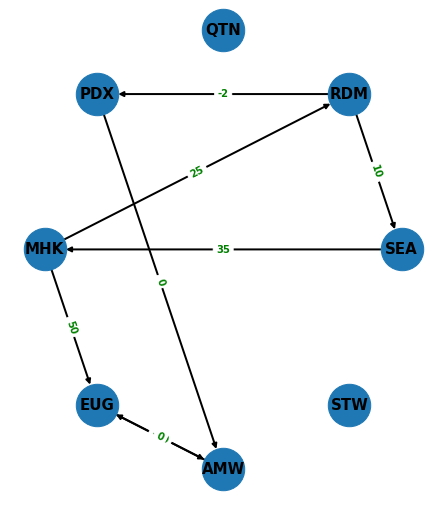

In [0]:
plot_directed_graph(flight_routes)

In [0]:
# inDegrees - inngoing connections. Attribute as dataframe
display(flight_routes.inDegrees)

id,inDegree
EUG,2
AMW,2
SEA,1
PDX,1
RDM,1
MHK,1


In [0]:
# outDegrees - outgoing connections. Attribute as dataframe
display(flight_routes.outDegrees)

id,outDegree
EUG,1
MHK,2
AMW,1
PDX,1
RDM,2
SEA,1


In [0]:
# total degrees (both for directed and undirected). Attribute as dataframe
display(flight_routes.degrees)

id,degree
EUG,3
AMW,3
MHK,3
PDX,2
RDM,3
SEA,2


In [0]:
# you can query attribute dataframes as usuall
flight_routes.inDegrees.filter('inDegree > 1').display()

id,inDegree
EUG,2
AMW,2


In [0]:
flight_routes.outDegrees.filter('outDegree > 1').display()

id,outDegree
MHK,2
RDM,2


In [0]:
low_traffic_airports = flight_routes.vertices.filter(flight_routes.vertices['total_flights'] < 30)

display(low_traffic_airports)

id,airport_name,total_flights
STW,Stowe,2
SEA,Seattle,10
QTN,Queenstown,1
PDX,Portland,3


All the operations above are performed on Graph Dataframe attributes, which are ordinary spark dataframes. And that returns the output in spark dataframe type also. Hovewer, we can query the Graph Dataframe itself

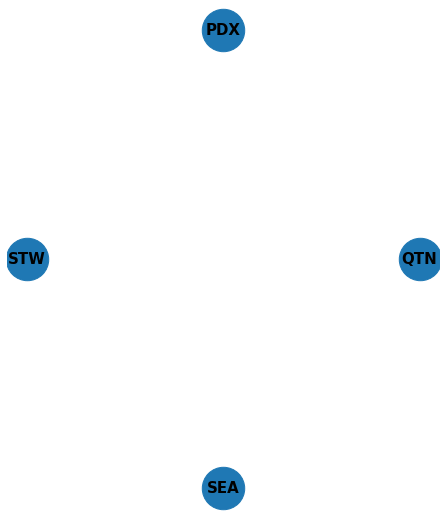

In [0]:
low_traffic_airports_graph = flight_routes.filterVertices('total_flights < 30')

plot_directed_graph(low_traffic_airports_graph)

In [0]:
# perform aggregation
max_operational_flights = flight_routes.vertices.groupBy().max('total_flights').withColumnRenamed('max(total_flights)', 'max_flights')
 
display(max_operational_flights)

max_flights
103


In [0]:
#access first row
max_operational_flights.first()['max_flights']

Out[27]: 103

In [0]:
# combine operations and pervorm filtering
max_flights_airport = flight_routes.vertices.filter("total_flights = {0}".format(max_operational_flights.first()['max_flights']))
 
display(max_flights_airport)

id,airport_name,total_flights
MHK,Manhattan,103


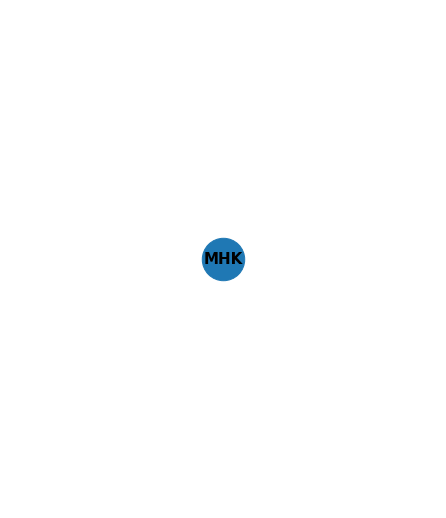

In [0]:
# to get the same result but not in the form of dataframe, 
# but as graph with the subset of nodes that matches the requirements use filterVertices()
max_flights_graph = flight_routes.filterVertices("total_flights = {0}".format(max_operational_flights.first()['max_flights']))

plot_directed_graph(max_flights_graph)

In [0]:
# filter edges
MHK_flights = flight_routes.edges.filter((col("src") == max_flights_airport.first()['id']) | (col("dst") == max_flights_airport.first()['id']))
 
display(MHK_flights)

src,dst,delay
MHK,EUG,50
SEA,MHK,35
MHK,RDM,25


In [0]:
# to perform query on Graph Frame instead of Data Frame
MHK_flights_graph = flight_routes.filterEdges((col("src") == max_flights_airport.first()['id']) | (col("dst") == max_flights_airport.first()['id']))
 
display(MHK_flights_graph.edges)

src,dst,delay
MHK,EUG,50
SEA,MHK,35
MHK,RDM,25


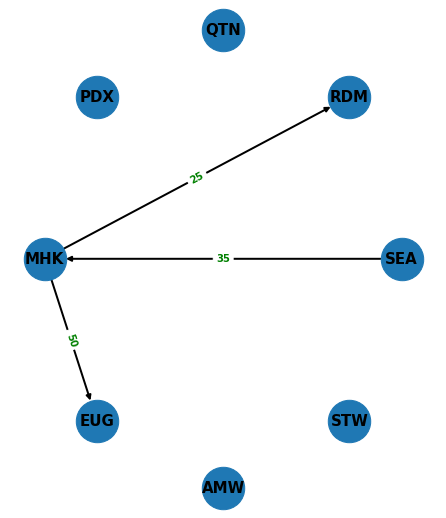

In [0]:
# call the function to observe result visually
plot_directed_graph(MHK_flights_graph)

In [0]:
no_delay = flight_routes.edges.filter("delay = 0").count()
 
print("The number of zero delay routes is: ", no_delay)

The number of zero delay routes is: 2

In [0]:
no_delay_routes = flight_routes.edges.filter("delay = 0")
 
display(no_delay_routes)

src,dst,delay
AMW,EUG,0
PDX,AMW,0


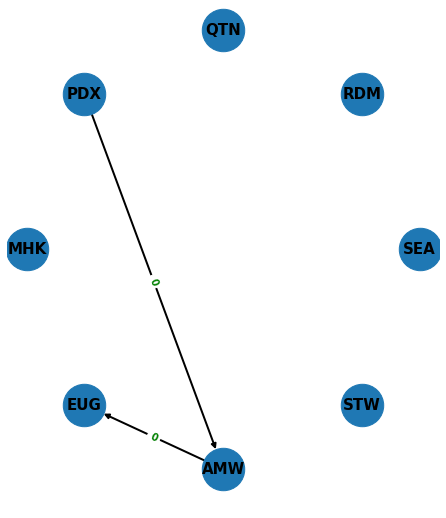

In [0]:
no_delay_graph = flight_routes.filterEdges("delay = 0")

plot_directed_graph(no_delay_graph)

In [0]:
num_early = flight_routes.edges.filter("delay < 0").count()
 
print("The number of early flights is: ", num_early)

The number of early flights is: 2

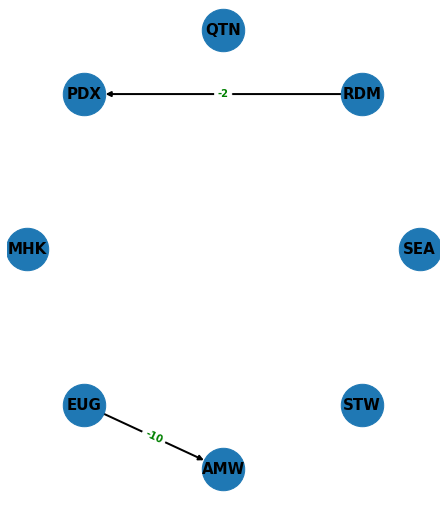

In [0]:
early_flights_graph = flight_routes.filterEdges("delay < 0")

plot_directed_graph(early_flights_graph)

In [0]:
max_delay = flight_routes.edges.groupBy().max('delay')
 
display(max_delay)

max(delay)
50


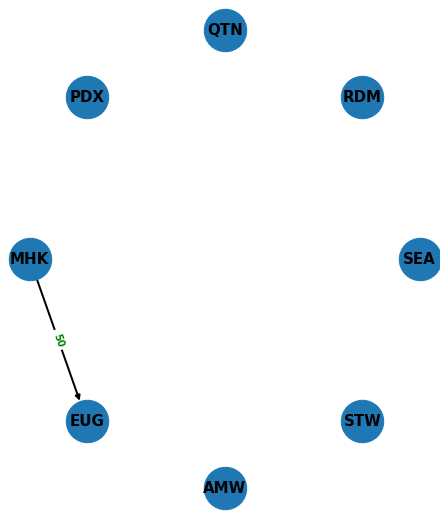

In [0]:
max_delay_graph = flight_routes.filterEdges("delay = {0}".format(max_delay.first()['max(delay)']))
 
plot_directed_graph(max_delay_graph)

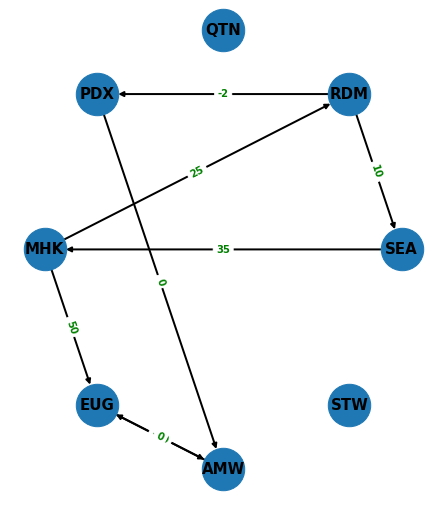

In [0]:
plot_directed_graph(flight_routes)

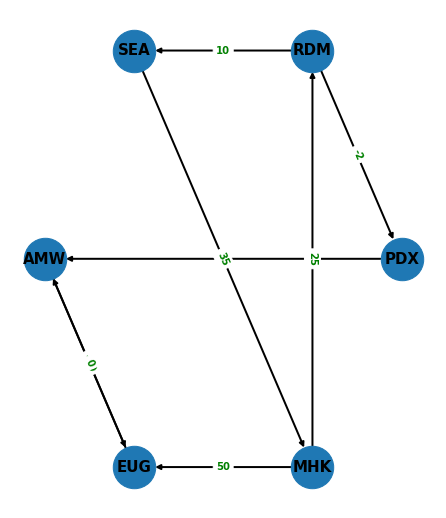

In [0]:
# drop isolated vertices
connected_cities = flight_routes.dropIsolatedVertices()

plot_directed_graph(connected_cities)